# DiT Recon Visualization

Load reconstructed TSVs from `checkpoints/dit/samples_epochXXX` and visualize. Adjust `epoch`/`num_show` if needed.

Found 2 TSVs under checkpoints/dit\samples_epoch001
G values per sample:
Pair_47_sim_hic_freq_recon: G=1.6002
Pair_5_sim_hic_freq_recon: G=1.6008
Saved visualization to checkpoints/dit\samples_epoch001\recon_vis_001.png


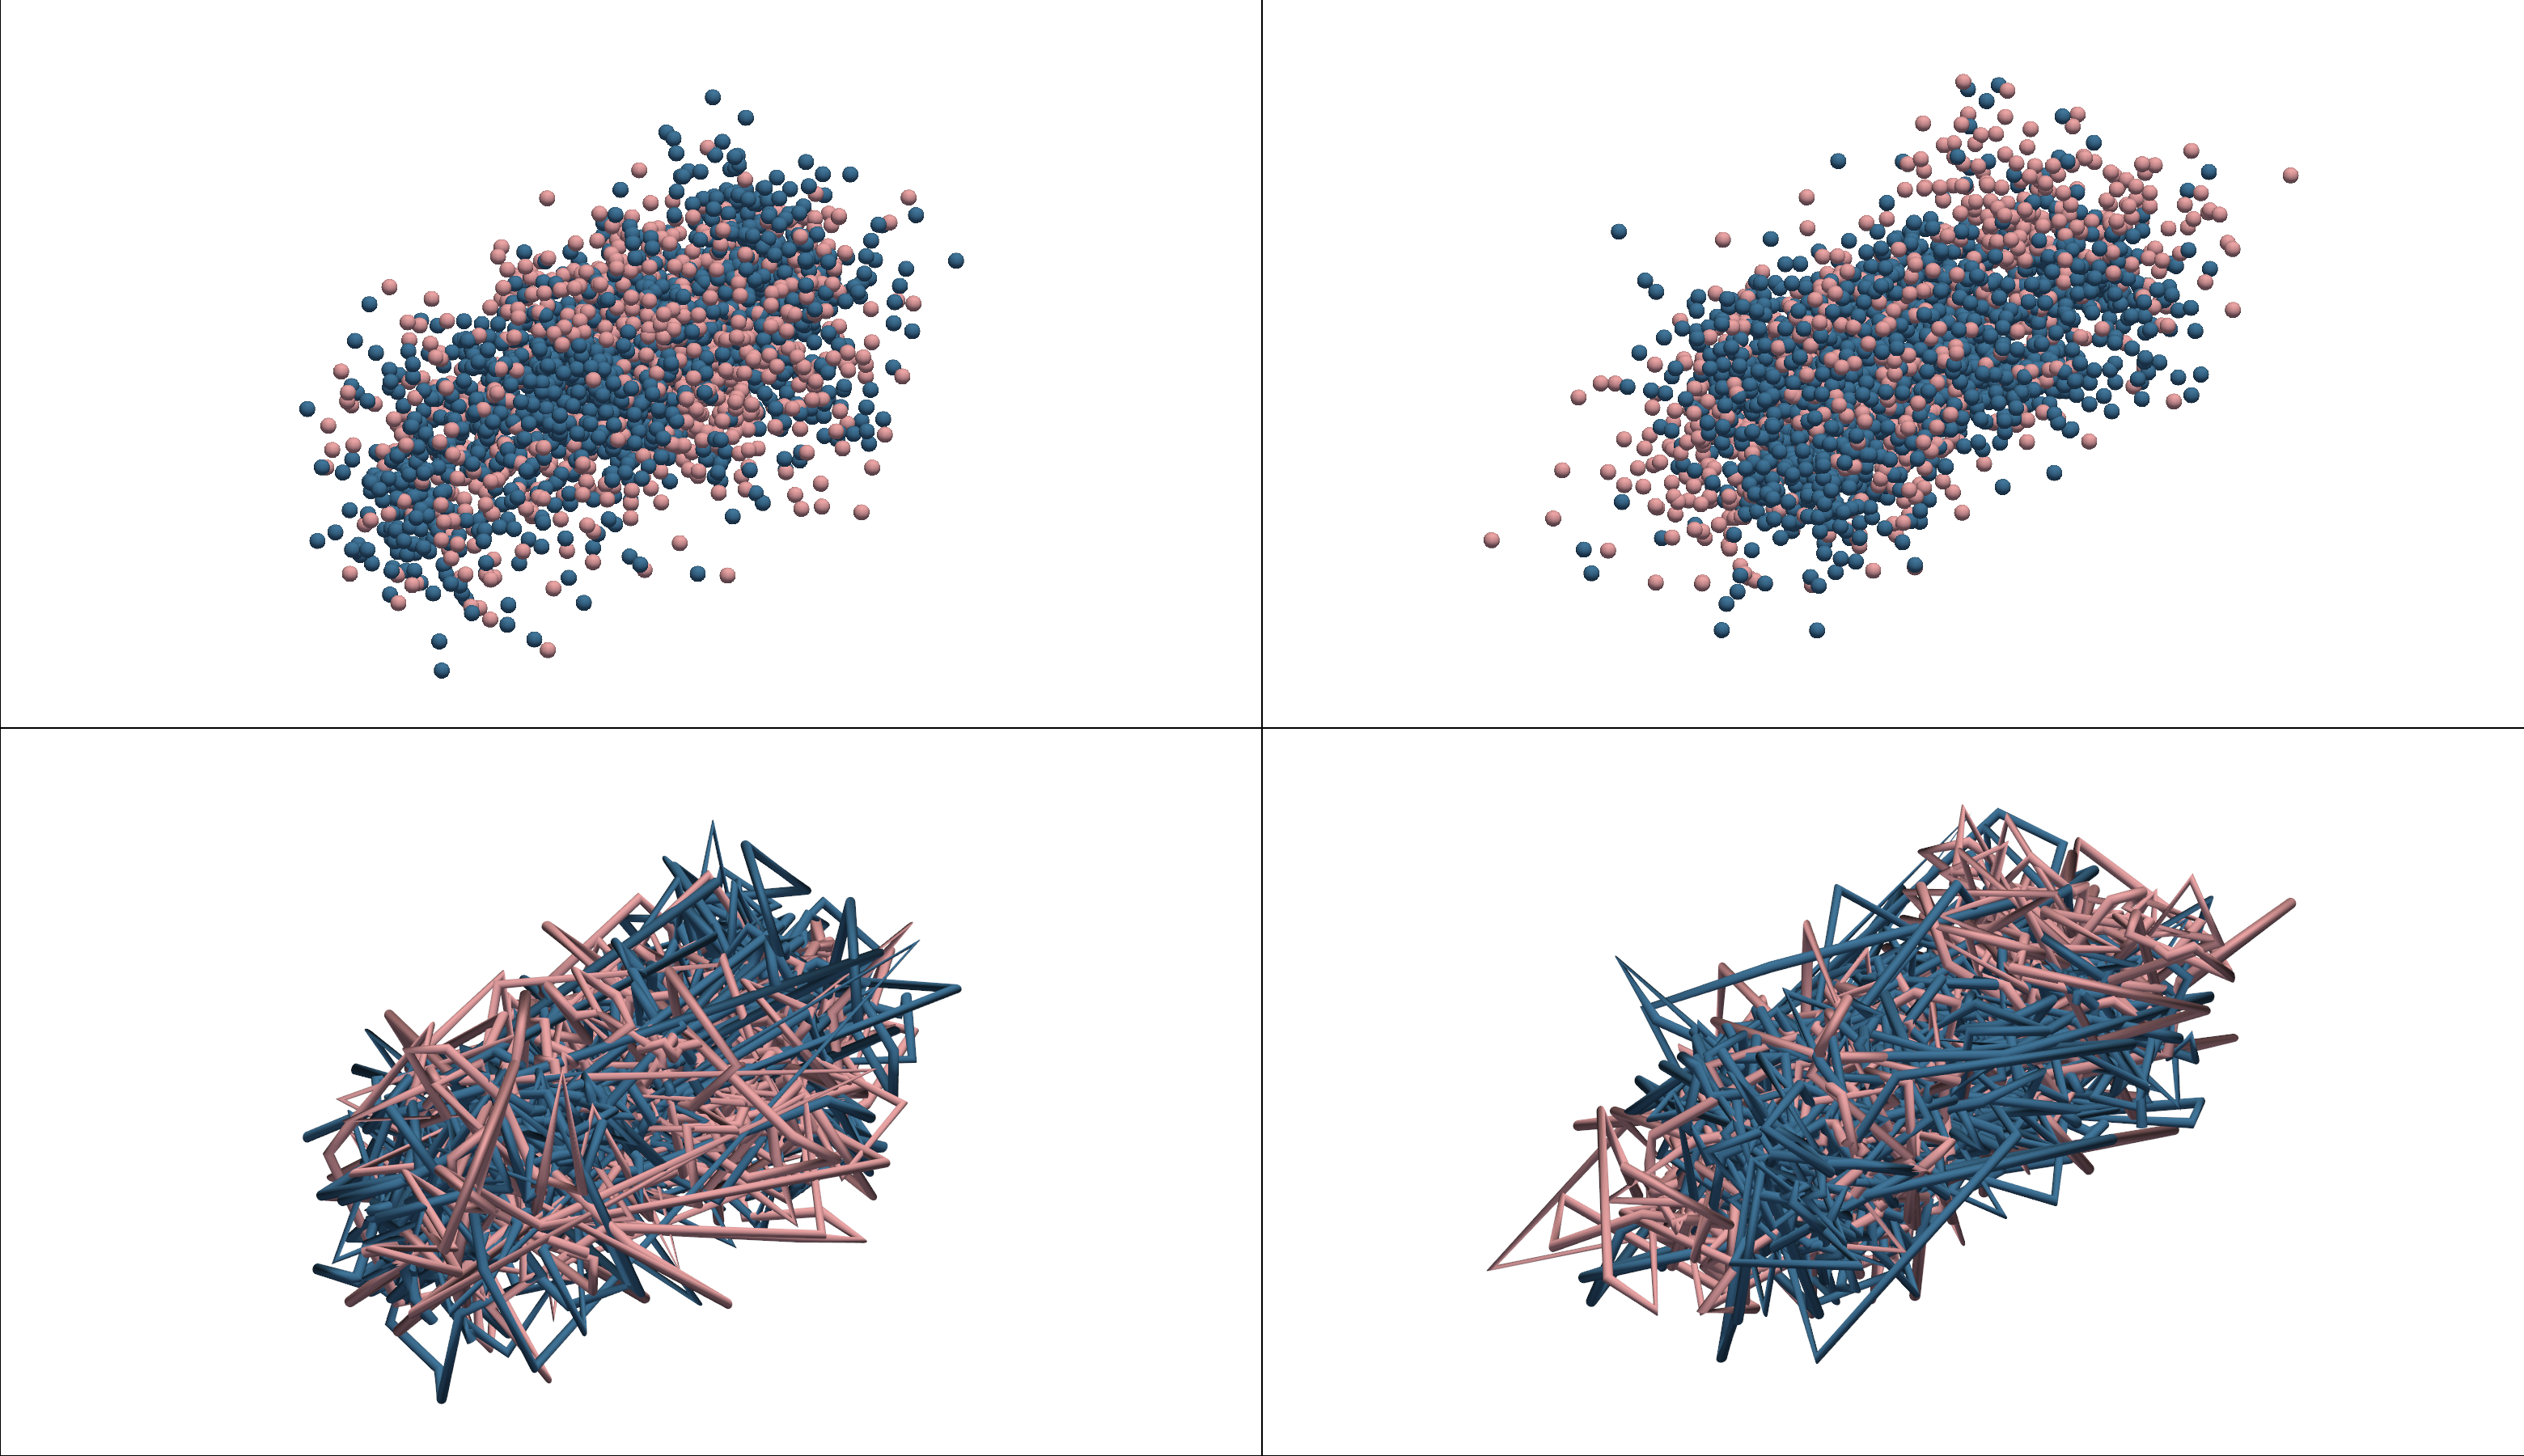

In [8]:
import os, glob, torch, numpy as np
from IPython.display import Image, display
from models.VAE.visualization import load_struct_tensor, extract_chain_coords, add_polyline
import numpy.linalg as LA
import pyvista as pv

# Settings
samples_dir = 'checkpoints/dit'  # root dir containing samples_epochXXX folders
epoch = '001'                     # change to desired epoch suffix


def pca_align(points: np.ndarray):
    center = points.mean(axis=0, keepdims=True)
    pts0 = points - center
    U, S, Vt = LA.svd(pts0, full_matrices=False)
    R = Vt.T
    if LA.det(R) < 0:
        R[:, -1] *= -1
    aligned = pts0 @ R
    return aligned, center, R


def compute_G(struct_tensor: torch.Tensor):
    chain_orig = ((struct_tensor[...,3]>0.5).sum() + (struct_tensor[...,11]>0.5).sum()).item()
    chain_copy = ((struct_tensor[...,7]>0.5).sum() + (struct_tensor[...,15]>0.5).sum()).item()
    if chain_orig == 0:
        return float('inf')
    return (chain_copy / chain_orig) + 1.0


tsv_dir = os.path.join(samples_dir, f'samples_epoch{epoch}')
tsv_files = sorted(glob.glob(os.path.join(tsv_dir, '*.tsv')))
print(f'Found {len(tsv_files)} TSVs under {tsv_dir}')
if len(tsv_files) == 0:
    raise SystemExit('No TSV files found')

orig_list, names, G_values = [], [], []
for p in tsv_files:
    struct_tensor, _ = load_struct_tensor(p, torch.device('cpu'))
    orig_list.append(struct_tensor.cpu())
    names.append(os.path.splitext(os.path.basename(p))[0])
    G_values.append(compute_G(struct_tensor.squeeze(0)))

print('G values per sample:')
for n, g in zip(names, G_values):
    print(f'{n}: G={g:.4f}')

orig_cat = torch.cat(orig_list, dim=0)
steel_blue = '#4682B4'
pink_light = '#FFB6C1'
colors = [('orig', steel_blue), ('copy', pink_light)]

total = orig_cat.size(0)
num_show = total
sel_idx = torch.randperm(total)[:num_show]
orig_cat = orig_cat[sel_idx]
names_sel = [names[i] for i in sel_idx]

plotter = pv.Plotter(shape=(2, num_show), window_size=(num_show * 520, 600), off_screen=True)


def set_cam(pl, pts, shrink=0.9):
    center = pts.mean(axis=0)
    max_range = np.ptp(pts, axis=0).max()
    max_range = max(max_range, 1e-3)
    offset = max_range * 2.0
    pl.camera.focal_point = center
    pl.camera.position = center + np.array([offset, offset, offset])
    pl.camera.up = (0,0,1)
    pl.camera.parallel_projection = True
    pl.camera.parallel_scale = (max_range * 0.5) * shrink

for i in range(num_show):
    struct = orig_cat[i]
    chains = []
    for tag, color in colors:
        x, y, z = extract_chain_coords(struct, tag)
        if len(x) == 0:
            continue
        pts = np.column_stack((x, y, z))
        chains.append((pts, color))
    if not chains:
        continue

    concat = np.concatenate([c[0] for c in chains], axis=0)
    aligned_all, center, R = pca_align(concat)
    transform = lambda pts: (pts - center) @ R

    # scatter row
    plotter.subplot(0, i)
    for pts, color in chains:
        plotter.add_points(transform(pts), color=color, point_size=20, render_points_as_spheres=True)
    set_cam(plotter, aligned_all)
    plotter.remove_bounds_axes()

    # line row
    plotter.subplot(1, i)
    for pts, color in chains:
        add_polyline(plotter, transform(pts), color=color, width=0.3)
    set_cam(plotter, aligned_all)
    plotter.remove_bounds_axes()

out_path = os.path.join(tsv_dir, f'recon_vis_{epoch}.png')
os.makedirs(tsv_dir, exist_ok=True)
plotter.screenshot(out_path, scale=3.0)
plotter.close()
print(f'Saved visualization to {out_path}')
display(Image(filename=out_path))
